In [1]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

import numpy as np

In [2]:
data_file = untar_data(URLs.CAMVID)

In [3]:
labels_file = data_file/'labels'
images_file = data_file/'images'

In [4]:
get_label = lambda x: labels_file/f'{x.stem}_P{x.suffix}'

In [5]:
class_names = np.loadtxt(data_file/'codes.txt', dtype=str)

In [6]:
defaults.device = torch.device('cuda')

size = [360, 480]
free = gpu_mem_get_free_no_cache()
if free > 8200:
  bs=8
else:
  bs=4

In [7]:
src = (
    SegmentationItemList.from_folder(images_file)
    .split_by_fname_file('../valid.txt')
    .label_from_func(get_label, classes=class_names)
    )
data = (
    src.transform(get_transforms(), size=size, tfm_y=True)
    .databunch(bs=bs).normalize(imagenet_stats)
    )

In [8]:
name2id = {v:k for k,v in enumerate(class_names)}
void_code = name2id['Void']

def accuracy(input, target):
    
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [9]:
acc = accuracy
wd = 1e-2
model = unet_learner(data, models.resnet34, metrics=acc, wd=wd)

In [12]:
model.fit(20)

epoch,train_loss,valid_loss,accuracy,time
0,0.737379,0.616916,0.834028,01:22
1,0.705911,0.636055,0.833673,01:22
2,0.645408,0.563447,0.852267,01:22
3,0.625799,0.532741,0.865809,01:22
4,0.588050,0.504468,0.864859,01:22
5,0.581155,0.511275,0.865205,01:22
6,0.554942,0.471742,0.868294,01:22
7,0.547797,0.570998,0.850465,01:22
8,0.524786,0.475257,0.870219,01:22
9,0.518068,0.437743,0.882591,01:22


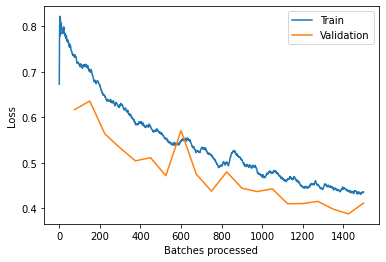

In [13]:
model.recorder.plot_losses()

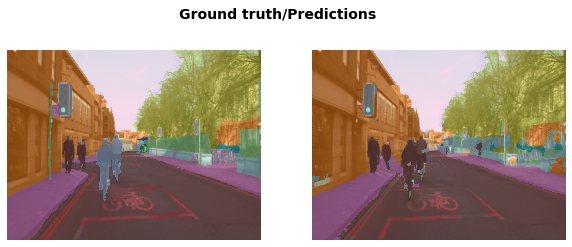

In [18]:
model.show_results(rows=1, figsize=(10,4), ds_type=DatasetType.Valid)